In [165]:
#import data from csv file
import pandas as pd
data = pd.read_csv('TCEHY.csv') #Apple stock price file
data = data.sort_values('Date')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-05,4.474,4.480,4.410,4.452,4.319740,76000
1,2010-01-06,4.480,4.482,4.470,4.482,4.348850,56000
2,2010-01-07,4.298,4.300,4.254,4.300,4.172257,49500
3,2010-01-08,4.290,4.360,4.290,4.358,4.228534,26000
4,2010-01-11,4.440,4.444,4.426,4.444,4.311979,134000


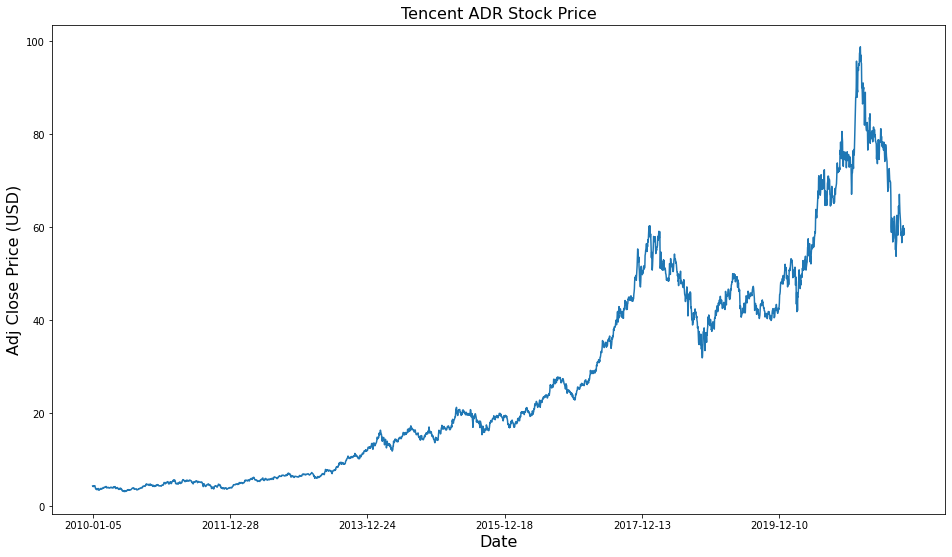

In [166]:
#plot the stock price (adjusted closing price)
import matplotlib.pyplot as plt
plt.figure(figsize = (16,9))
plt.plot(data[['Adj Close']])
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500])
plt.title("Tencent ADR Stock Price",fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Adj Close Price (USD)',fontsize=16)
plt.show()

In [167]:
import numpy as np
price = data[['Adj Close']]
print(price)




      Adj Close
0      4.319740
1      4.348850
2      4.172257
3      4.228534
4      4.311979
...         ...
2952  60.340000
2953  59.000000
2954  58.299999
2955  59.770000
2956  58.820000

[2957 rows x 1 columns]


In [168]:
# MinMax Scale that use the min and max of the first half of the group
def MinMaxScale(data_lookback):
    data_new = ((data_lookback-data_lookback[:int(len(data_lookback)/2)].min())
                /(data_lookback[:int(len(data_lookback)/2)].max()-data_lookback[:int(len(data_lookback)/2)].min()))
    return data_new
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    data_Real = []

    # create all possible sequences of length lookback
    for i in range(len(data_raw) - lookback):
        data.append(MinMaxScale(data_raw[i: i + lookback]))
        data_Real.append(data_raw[i: i + lookback])

    data = np.array(data)
    data_Real=np.array(data_Real)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test, data_Real]

lookback = 20 # use the previous 19 days to predict the 20th day
x_train, y_train, x_test, y_test, data_Real = split_data(price, lookback)





In [169]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)


In [170]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [171]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out


In [172]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)


In [173]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  2.3532114028930664
Epoch  1 MSE:  2.06783127784729
Epoch  2 MSE:  1.789560079574585
Epoch  3 MSE:  1.4471129179000854
Epoch  4 MSE:  1.138848066329956
Epoch  5 MSE:  1.3255935907363892
Epoch  6 MSE:  1.1874955892562866
Epoch  7 MSE:  0.9724411964416504
Epoch  8 MSE:  0.8882881999015808
Epoch  9 MSE:  0.8652111291885376
Epoch  10 MSE:  0.8207132816314697
Epoch  11 MSE:  0.7302013635635376
Epoch  12 MSE:  0.6096895933151245
Epoch  13 MSE:  0.5110231041908264
Epoch  14 MSE:  0.49625644087791443
Epoch  15 MSE:  0.5181484222412109
Epoch  16 MSE:  0.4783109128475189
Epoch  17 MSE:  0.4342702627182007
Epoch  18 MSE:  0.42978984117507935
Epoch  19 MSE:  0.42541226744651794
Epoch  20 MSE:  0.39909908175468445
Epoch  21 MSE:  0.3593674302101135
Epoch  22 MSE:  0.32593607902526855
Epoch  23 MSE:  0.3119726777076721
Epoch  24 MSE:  0.3117377460002899
Epoch  25 MSE:  0.3079972565174103
Epoch  26 MSE:  0.2947971224784851
Epoch  27 MSE:  0.28097832202911377
Epoch  28 MSE:  0.2733485102

In [174]:
predict = pd.DataFrame(y_train_pred.detach().numpy())
original = pd.DataFrame(y_train_lstm.detach().numpy())

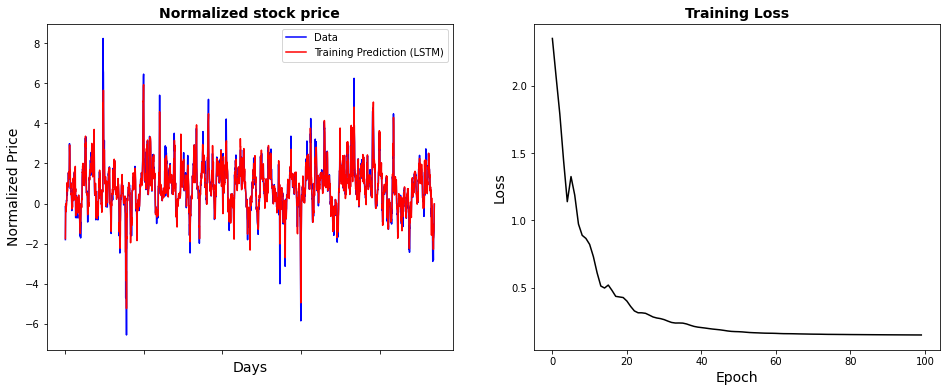

In [175]:
import seaborn as sns


fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='blue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='red')
ax.set_title('Normalized stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Normalized Price", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='black')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [176]:
# A function for recovering the real price from the normalized price
def RecoverReal(x,predict):
    predict_real = []
    for i in range(len(predict)):
        predict_real.append(predict[i]*(x[i][:int(len(x[i])/2)].max()-x[i][:int(len(x[i])/2)].min())
                            +x[i][:int(len(x[i])/2)].min())
    predict_real = np.array(predict_real)
    return  predict_real

# make predictions
y_test_pred = model(x_test)

y_train_pred = y_train_pred.detach().numpy()
y_train = y_train_lstm.detach().numpy()
y_test_pred = y_test_pred.detach().numpy()
y_test = y_test_lstm.detach().numpy()


# shift train predictions for plotting
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = RecoverReal(data_Real[:len(y_train),:-1,:],y_train_pred)

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = RecoverReal(data_Real[len(y_train):,:-1,:],y_test_pred)

original = price['Adj Close'].values.reshape(-1,1)

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

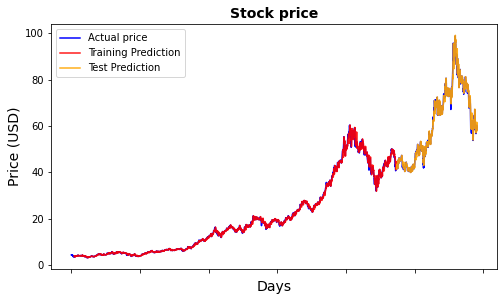

In [177]:
fig2=plt.figure(figsize = (8,4.5))
ax = sns.lineplot(x=result.index, y=result[2], label="Actual price", color='blue')
ax = sns.lineplot(x=result.index, y=result[0], label="Training Prediction", color='red',alpha=0.9)
ax = sns.lineplot(x=result.index, y=result[1], label="Test Prediction", color='orange',alpha=0.9)
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Price (USD)", size = 14)
ax.set_xticklabels('', size=10)
plt.show()
fig2.savefig('Stockprice.png')
